In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import datetime
from datetime import date, timedelta, datetime
import warnings
from itertools import product
from scipy import stats
from sklearn import linear_model
import statsmodels.api as sm
import requests
from bs4 import BeautifulSoup
import re
warnings.filterwarnings("ignore")
%matplotlib inline

In [43]:
factors = pd.read_excel(r'145_factors.xlsx',  index_col = [0])
factors.drop('Субъект', axis=1, inplace=True)

In [44]:
factors.columns = factors.iloc[1]+'-'+factors.iloc[0]
factors.drop('01-12-2016', axis=1, inplace=True)

In [45]:
factors_nsk, factors_psk, factors_tvr = factors.iloc[2:, :48].T, factors.iloc[2:, 48:96].T, factors.iloc[2:, 96:].T

In [46]:
factors_nsk.index = pd.to_datetime(factors_nsk.index, format='%d-%m-%Y')
factors_psk.index = pd.to_datetime(factors_psk.index, format='%d-%m-%Y')
factors_tvr.index = pd.to_datetime(factors_tvr.index, format='%d-%m-%Y')

In [47]:
soc_supp_cols = ['Регион', 'Код_региона', '06-06-2016', '12-12-2016', '06-06-2017', '12-12-2017', '06-06-2018', '12-12-2018', '06-06-2019']
file_name = r'13151000200220200001_Расходы_консолидированного_бюджета_субъекта_Российской_Федерации__на_реализацию.xlsx'
soc_supp = pd.read_excel(file_name,
                        names = soc_supp_cols,  index_col = [0]).iloc[4:].drop('Код_региона', axis=1).T
soc_supp.index = pd.to_datetime(soc_supp.index, format='%d-%m-%Y')

In [48]:
factors_nsk = factors_nsk.join(soc_supp['Новосибирская область'])
factors_psk = factors_psk.join(soc_supp['Псковская область'])
factors_tvr = factors_tvr.join(soc_supp['Тверская область'])

In [49]:
file_name = r'11522140300010200001_Индексы_тарифов_на_грузовые__перевозки.xlsx'
trucking = pd.read_excel(file_name,  index_col = [0]).iloc[3:, 1:]

In [50]:
dates=[]
for j in [2016, 2017, 2018, 2019]:
    for i in range(1, 13):
        dates.append(str(i)+'-'+str(i)+'-'+str(j))
dates.append('1-1-2020')
trucking.columns=dates
trucking = trucking.T
trucking.index = pd.to_datetime(trucking.index, format='%d-%m-%Y')

In [51]:
factors_nsk = factors_nsk.join(trucking['Новосибирская область'], rsuffix="_тарифы_грузоперевозок")
factors_psk = factors_psk.join(trucking['Псковская область'], rsuffix="_тарифы_грузоперевозок")
factors_tvr = factors_tvr.join(trucking['Тверская область'], rsuffix="_тарифы_грузоперевозок")

#### Таблицы по регионам выглядят таким образом

In [52]:
factors_tvr.tail()

,"02.20.1 Лесоматериалы необработанные (с 2017 г.), тыс. плотн. куб. м","08.12.12.140 Щебень (с 2017 г.), тыс. куб. м","10.11.1 Мясо крупного рогатого скота, свинина, баранина, козлятина, конина и мясо прочих животных семейства лошадиных, оленина и мясо прочих животных семейства оленьих (оленевых) парные, остывшие или охлажденные (с 2017 г.), т","10.13.14.610 Продукты из мяса (с 2017 г.), т","10.51.40.100 Сыры (с 2017 г.), т","10.51.40.300 Творог (с 2017 г.), т","ГОСУДАРСТВЕННАЯ ПОШЛИНА, тыс. руб.","ДОХОДЫ (налоговые и неналоговые доходы; без учета безвозмездных поступлений и доходов от предпринимательской деятельности) (с 2005 г.), тыс. руб.","Доля малых предприятий по виду экон. деятельности ""Транспорт и связь"" от общего числа малых предприятий (на конец года), %","Дотации на выравнивание уровня бюджетной обеспеченности (с 2002 г.), тыс. руб.",...,"Просроченная кредиторская задолженность крупных и средних организаций (на конец отчетного периода), млн. руб.","Среднемесячная начисленная зарплата (за месяц), руб.","Средства внебюджетных фондов на счетах кредитных организаций (на 1 число след. квартала) (до 01.10.2007 - тыс. руб.), млн. руб.","Сумма операций по банковским картам юридических лиц (по месту регистрации кредитных организаций (их филиалов) - эмитентов карт), всего (до 01.04.2017 Москва и МО суммарно) (за квартал), млн. руб.","Телевидение и радиовещание, тыс. руб.","Транспорт, тыс. руб.","Численность населения (на конец года), тыс. чел.","Число автобусов общего пользования на 100 тыс. человек населения (на конец года), шт.",Тверская область,Тверская область_тарифы_грузоперевозок
2019-08-08,335.75,131.6,10779.6,NaN,16.25,618.29,262495,3.99188e+07,NaN,NaN,...,32099,32322,NaN,NaN,20444.7,409184,NaN,NaN,NaN,101.72
2019-09-09,375.25,121.8,10453.2,NaN,14.67,696.77,294895,4.37233e+07,NaN,NaN,...,27658,33246,0,3327.4,22726.6,471439,NaN,NaN,NaN,101.72
2019-10-10,361.25,121.3,10425.2,NaN,15.9,697.9,332012,5.18839e+07,NaN,NaN,...,28889,33004,NaN,NaN,24867.1,539295,NaN,NaN,NaN,101.71
2019-11-11,349.86,154,10315.5,NaN,14.33,795.13,367297,5.65758e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,27131,603803,NaN,NaN,NaN,101.71
2019-12-12,332.75,135,10537.3,NaN,14.31,634.04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.71


#### Поскольку есть пропущенные значения, a сама искомая величина ИПР подсчитывалась раз в год, то для регрессии имеет смысл суммировать показатели по годам.

In [53]:
res_nsk = factors_nsk.groupby(factors_nsk.index.year).sum()
res_psk = factors_psk.groupby(factors_psk.index.year).sum()
res_tvr = factors_tvr.groupby(factors_tvr.index.year).sum()

In [54]:
res_psk

,"02.20.1 Лесоматериалы необработанные (с 2017 г.), тыс. плотн. куб. м","08.12.12.140 Щебень (с 2017 г.), тыс. куб. м","10.11.1 Мясо крупного рогатого скота, свинина, баранина, козлятина, конина и мясо прочих животных семейства лошадиных, оленина и мясо прочих животных семейства оленьих (оленевых) парные, остывшие или охлажденные (с 2017 г.), т","10.13.14.610 Продукты из мяса (с 2017 г.), т","10.51.40.100 Сыры (с 2017 г.), т","10.51.40.300 Творог (с 2017 г.), т","ГОСУДАРСТВЕННАЯ ПОШЛИНА, тыс. руб.","ДОХОДЫ (налоговые и неналоговые доходы; без учета безвозмездных поступлений и доходов от предпринимательской деятельности) (с 2005 г.), тыс. руб.","Доля малых предприятий по виду экон. деятельности ""Транспорт и связь"" от общего числа малых предприятий (на конец года), %","Дотации на выравнивание уровня бюджетной обеспеченности (с 2002 г.), тыс. руб.",...,"Просроченная кредиторская задолженность крупных и средних организаций (на конец отчетного периода), млн. руб.","Среднемесячная начисленная зарплата (за месяц), руб.","Средства внебюджетных фондов на счетах кредитных организаций (на 1 число след. квартала) (до 01.10.2007 - тыс. руб.), млн. руб.","Сумма операций по банковским картам юридических лиц (по месту регистрации кредитных организаций (их филиалов) - эмитентов карт), всего (до 01.04.2017 Москва и МО суммарно) (за квартал), млн. руб.","Телевидение и радиовещание, тыс. руб.","Транспорт, тыс. руб.","Численность населения (на конец года), тыс. чел.","Число автобусов общего пользования на 100 тыс. человек населения (на конец года), шт.",Псковская область,Псковская область_тарифы_грузоперевозок
2016,0.00,0.00,0.00,0.00,0.00,0.00,331870.50,4.587070e+07,9.14,8949861.1,...,25624,267290,0,1935.40,2061.08,1112966.72,642,155.26,2509965.00,1198.92
2017,665.69,329.87,131891.44,4655.01,13153.05,2367.78,982351.09,1.221722e+08,7.90,24802042.0,...,64348,279942,0,4738.30,0.00,2760698.53,636,155.00,2522319.00,1212.79
2018,1051.47,414.10,98929.65,13430.34,13629.30,1976.51,1059704.03,1.351755e+08,8.42,0.0,...,36819,322352,0,10263.06,0.00,2840477.02,630,150.00,2937537.99,1219.59
2019,1055.68,596.60,96981.89,13930.93,10256.56,2107.34,934751.31,1.234455e+08,0.00,0.0,...,32909,286600,0,3794.46,0.00,2394013.38,0,0.00,1227969.00,1228.70


#### В данных всех трех регионов было обнаружено, что по 2 признакам, значение которых не могло радикально измениться, нет значений за 2019 год. Заполним по предыдущему.

In [55]:
for el in ['Численность населения (на конец года), тыс. чел.', 
         'Число автобусов общего пользования на 100 тыс. человек населения (на конец года), шт.']:
    for tab in [res_nsk, res_psk, res_tvr]:
        tab[el][2019] = tab[el][2018]

#### С сайта ra-national.ru вручную взял рейтинг регионов за 2106-2019 годы., т.к. таблицы в PDF
(меньшее число обозначиает большую привлекательность)

In [56]:
cols = ['Тверская область', 'Псковская область', 'Новосибирская область']
rating = pd.DataFrame(np.array([[7, 8, 5], [7, 8, 4], [8, 7, 4], [6, 7, 4]]),
                   columns=cols, index = [2016, 2017, 2018, 2019])

In [57]:
rating

,Тверская область,Псковская область,Новосибирская область
2016,7,8,5
2017,7,8,4
2018,8,7,4
2019,6,7,4


#### В качестве переменной, имеющей количественное обозначение, использую долю инвестиционного потенциала регионов в общероссийском в 2017 году (по ней можно аппроксимировать доли в последующих годах)

In [58]:
url = 'https://www.raexpert.ru/rankingtable/region_climat/2017/tab3'
r = requests.get(url)
r.encoding = 'utf-8' 
soup = BeautifulSoup(r.text)
parse_table = str(soup.find('div', {'class': 'table_content_scroll'}))

In [59]:
nsk_2017 = float((re.findall('Новосибирская область</a></td><td align="left" class="ranking_content" colspan="" rowspan="">(.+?)</td><td align="left" class="ranking_content" colspan="" rowspan="">', parse_table))[0])
psk_2017 = float((re.findall('Псковская область</a></td><td align="left" class="ranking_content" colspan="" rowspan="">(.+?)</td><td align="left" class="ranking_content" colspan="" rowspan="">', parse_table))[0])
tvr_2017 = float((re.findall('Тверская область</a></td><td align="left" class="ranking_content" colspan="" rowspan="">(.+?)</td><td align="left" class="ranking_content" colspan="" rowspan="">', parse_table))[0])

In [60]:
potential = pd.DataFrame(np.array([[nsk_2017, psk_2017, tvr_2017]]), 
                         columns=['Новосибирская область', 'Псковская область','Тверская область']).T
potential.columns=[2017]

## Обучим и провалидируем модель

In [61]:
datasets = [res_tvr, res_psk, res_nsk]
for element, data in zip(cols, datasets):
    clf = linear_model.LogisticRegression(random_state=0).fit(data[:3], rating[element][:3])
    print(element, ':', sep='')
    print('Предсказанное значение: ', int(clf.predict(data[3:])), ', истинное: ', int(rating[element][3:].values), sep='')

Тверская область:
Предсказанное значение: 8, истинное: 6
Псковская область:
Предсказанное значение: 7, истинное: 7
Новосибирская область:
Предсказанное значение: 4, истинное: 4


#### Модель ошиблась в 1 случае, попробуем объединить все признаковые пространства (удалив названия признаков) и, обучившись на них, повторить прогноз

In [62]:
co = range(1, 40)
res_tvr.columns, res_nsk.columns, res_psk.columns = co, co, co

In [63]:
clf = linear_model.LogisticRegression(random_state=0).fit(pd.concat([res_tvr[:3], res_nsk, res_psk]), 
                                             pd.concat([rating['Тверская область'][:3], rating['Новосибирская область'], rating['Псковская область']]))

In [64]:
print('Предсказанное значение: ', int(clf.predict(res_tvr[3:])), ', истинное: ', int(rating['Тверская область'][3:]), sep='')

Предсказанное значение: 8, истинное: 6


#### Поскольку ошибка повторилась, вероятно, что при оценке инвестиционной привлекательности Тверской области сыграл фактор, не нашедший отражения в признаковом пространстве. Не менее вероятно, что верный результат на Псковской и Новосибирской областях - такое же совпадение. 

#### Офтоп: доля и прогноз доли регионов в общероссийском потенциале

In [65]:
reg = linear_model.Lasso(alpha=0.05).fit(X=pd.concat([res_tvr.iloc[1], res_nsk.iloc[1], res_psk.iloc[1]], axis=1).T, y=potential)

In [66]:
potential[2018]=reg.predict(pd.concat([res_tvr.iloc[2], res_nsk.iloc[2], res_psk.iloc[2]], axis=1).T).tolist()
potential[2019]=reg.predict(pd.concat([res_tvr.iloc[3], res_nsk.iloc[3], res_psk.iloc[3]], axis=1).T).tolist()

In [67]:
potential

,2017,2018,2019
Новосибирская область,1.503,1.618174,1.812079
Псковская область,0.490,0.557114,0.547053
Тверская область,0.695,0.905922,0.910549


Если бы доля этих регионов в общероссийском потенциаде действительно росла так...
Здесь можно увидеть лишь тенденцию показателей нашего ряда увеличиваться для всех регионов и давать больший результат при подстановке в обученное регрессией уравнение.

## Построим предсказание значений каждого признака на конец 2020 года и по ним предскажем обученной моделью ИПР

In [68]:
factors_nsk.columns = range(1, 40)
factors_psk.columns = range(1, 40)
factors_tvr.columns = range(1, 40)

### Среди признаков есть несколько типов, для каждого подберем стратегию предсказания его значений на 2020 год:
#### Линеный ряд применим там, где:
- есть все значения с 2017 года (1-8, 11, 12, 16, 20-25, 27, 29-31, 34-35, 39) - за 2016 год заполним ближайшим известным
- есть пропущенные значения в данных с 2016 года (19 - NaN заполним нулями)
- есть значения за каждый квартал (13-14, 15, 17, 18, 26, 28, 32-33)
- есть значения за каждые полгода с 6.2017 (38)
#### Линеный ряд не применим там, где мало значений:
- показатель выставлялся раз в год (9, 36-37) - выставляем среднее последних двух значений
- есть значения показателя до 2019 года (10) - выставляем 0

In [69]:
for a in [1,2,3,4,5,6,7,8,11,12,16,20,21,22,23,24,25,27,29,30,31,34,35,39]:
    factors_nsk[a] = factors_nsk[a].bfill()

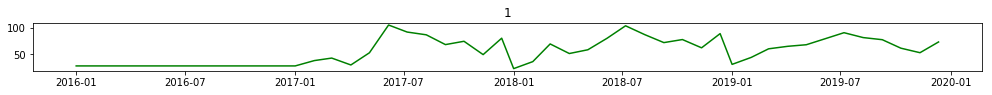

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.03512557371319286


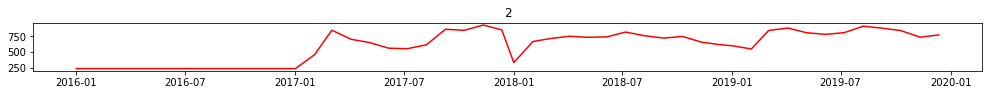

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.2353884442326244


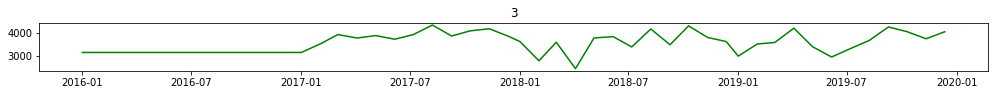

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.0004807632116044073


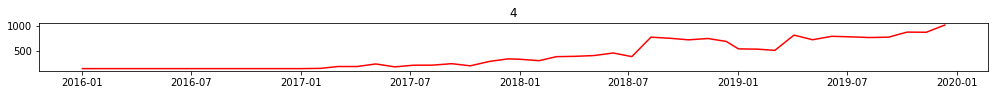

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.9527826647078603


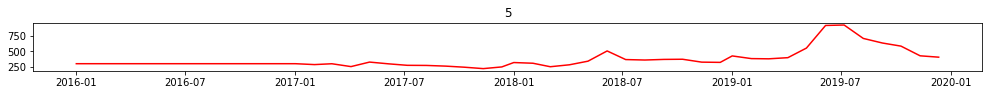

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.11545544516944739


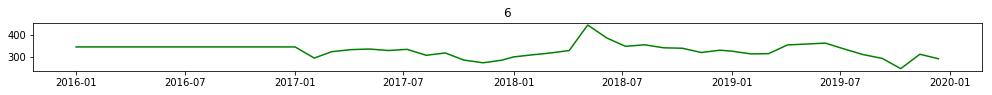

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.012855518728328571


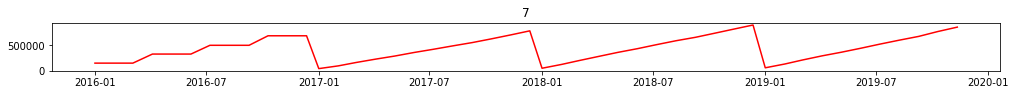

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.4382787719702812


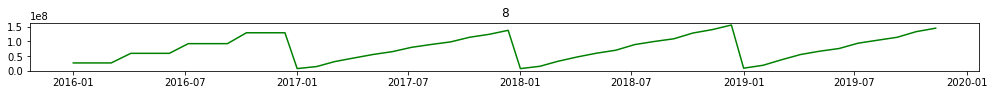

Пропущено значений: 0 , критерий Дики-Фуллера: p = 1.100246756160431e-06


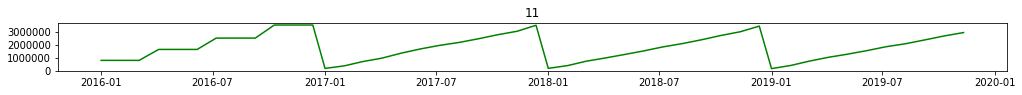

Пропущено значений: 0 , критерий Дики-Фуллера: p = 1.9659802434775368e-05


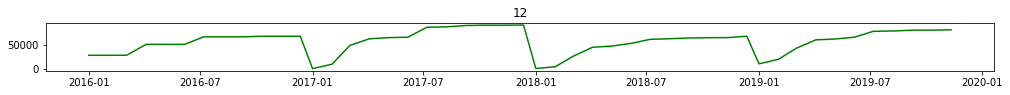

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.0035272732977848584


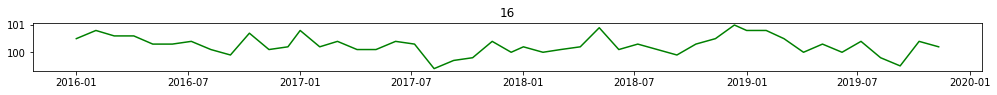

Пропущено значений: 0 , критерий Дики-Фуллера: p = 6.131123885146403e-05


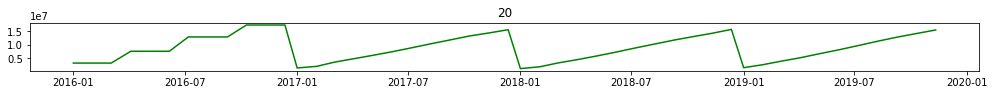

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.00010662983628550973


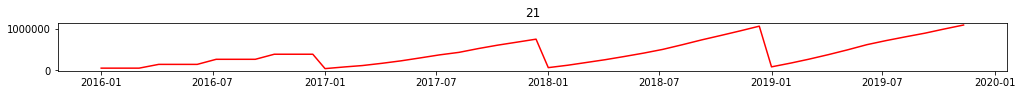

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.3026826232349078


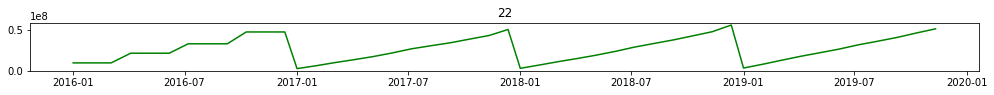

Пропущено значений: 0 , критерий Дики-Фуллера: p = 9.096977567146543e-05


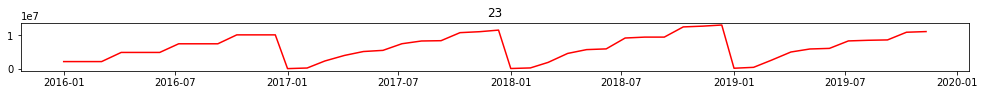

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.44383750140270295


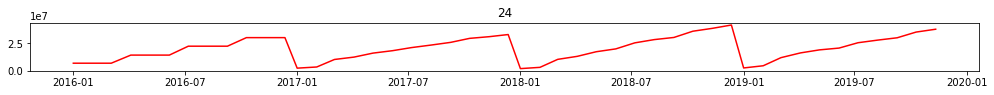

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.548775404523734


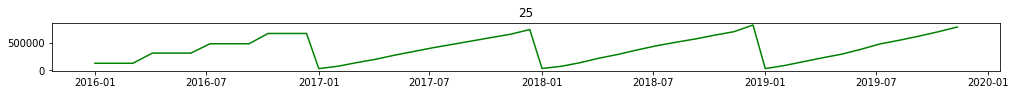

Пропущено значений: 0 , критерий Дики-Фуллера: p = 8.952529927783487e-07


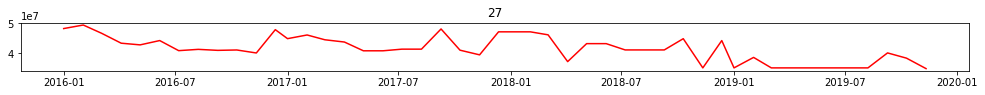

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.1452206348251321


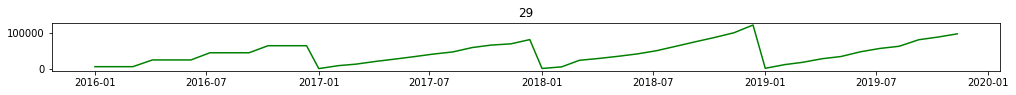

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.03416186202494068


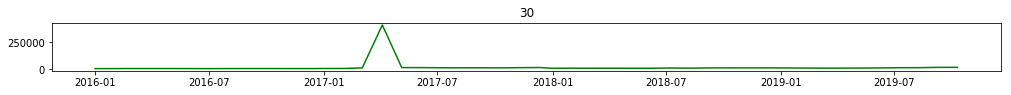

Пропущено значений: 0 , критерий Дики-Фуллера: p = 5.104663140281249e-09


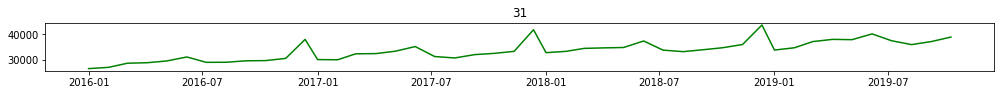

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.7363744134480722


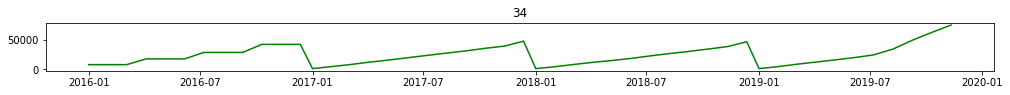

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.000751700482403078


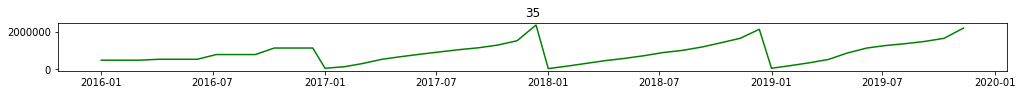

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.017261067426981812


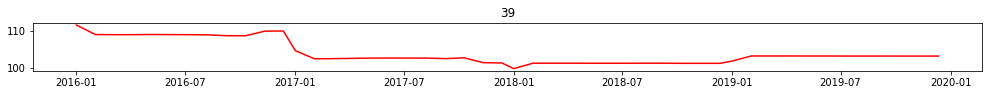

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.43180157820798465
Wall time: 4.22 s


In [70]:
%%time
for element in [1,2,3,4,5,6,7,8,11,12,16,20,21,22,23,24,25,27,29,30,31,34,35,39]:
    c='g'
    if sm.tsa.stattools.adfuller(factors_nsk[element][:-1])[1] > 0.05:
        c='r'
    plt.figure(figsize=(17,3))
    ax=plt.subplot(311)
    plt.title(element)
    plt.plot(factors_nsk[element], c=c)
    plt.show()
    if factors_nsk[element].isna().sum() > 1:
        factors_nsk[element][-2]=factors_nsk[element][-3]
    print("Пропущено значений:", factors_nsk[element][:-1].isna().sum(), 
          ", критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(factors_nsk[element][:-1])[1])

Ряды, отрисованные красным, по критерию Дики-Фулера являются нестационарными. Невозможно предусмотреть поведение того процесса, в основе которого нестационарный временной ряд (математическое ожидание, дисперсия и автоковариация его меняются в зависимости от времени), поэтому следует искать возможные преобразования ряда, которые могут свести его к стационарному. 
Так, если посмотреть на ряды 7, 8, 11 и 12 - они схожи и стационарность 8, 11 и 12 рядов, так же как и 20, 22, 25, 29, 34 и 35 не подтверждается.
Итого из первой группы имеем:

In [71]:
# стационарные ряды:
a_stat = [1, 2, 3, 6, 16, 27, 30]
# нестационарные ряды:
a_nonstat = [4, 5, 7, 8, 11, 12, 20, 21, 22, 23, 24, 25, 29, 31, 34, 35, 39]

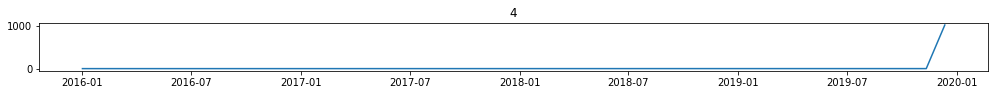

Оптимальный параметр преобразования Бокса-Кокса:  -0.21165721357818124
Критерий Дики-Фуллера: p = 0.9285068393173146


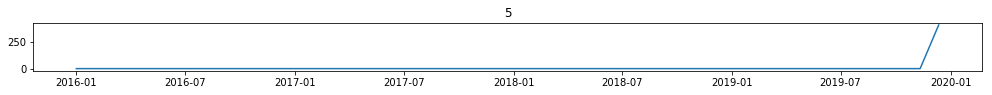

Оптимальный параметр преобразования Бокса-Кокса:  -1.8796810436652558
Критерий Дики-Фуллера: p = 0.3345184210074343


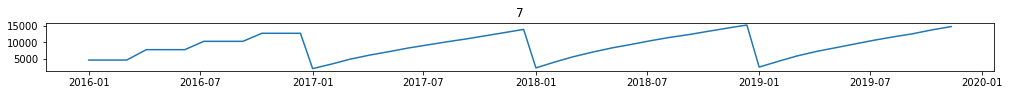

Оптимальный параметр преобразования Бокса-Кокса:  0.6744277682306246
Критерий Дики-Фуллера: p = 0.018268534615203405


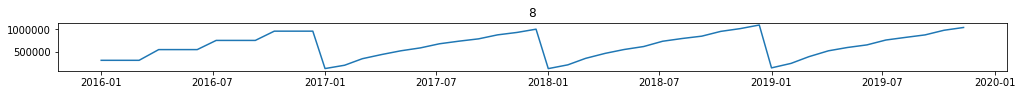

Оптимальный параметр преобразования Бокса-Кокса:  0.7196864799793976
Критерий Дики-Фуллера: p = 6.873129050933835e-05


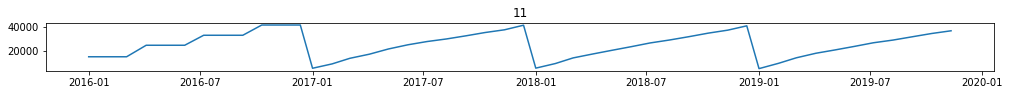

Оптимальный параметр преобразования Бокса-Кокса:  0.6793294112447343
Критерий Дики-Фуллера: p = 0.00010535068829871922


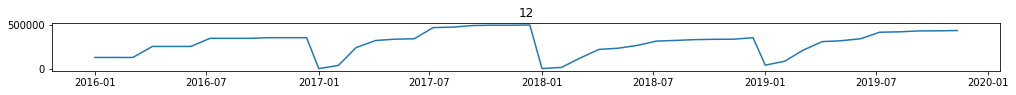

Оптимальный параметр преобразования Бокса-Кокса:  1.16072195586909
Критерий Дики-Фуллера: p = 0.005404741673053394


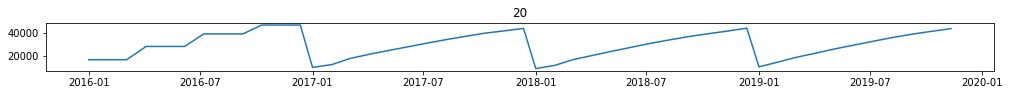

Оптимальный параметр преобразования Бокса-Кокса:  0.6157134952884818
Критерий Дики-Фуллера: p = 3.0783656880032945e-05


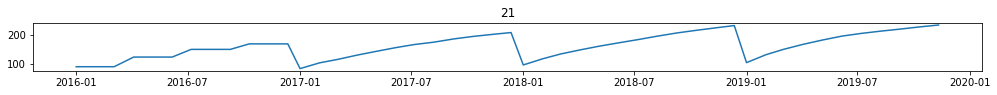

Оптимальный параметр преобразования Бокса-Кокса:  0.30899887108755214
Критерий Дики-Фуллера: p = 0.08956502723418902


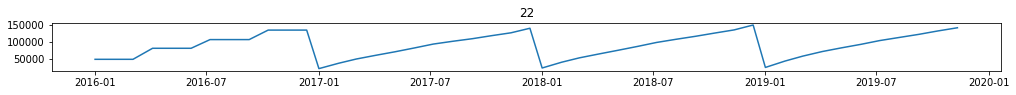

Оптимальный параметр преобразования Бокса-Кокса:  0.6434501305714824
Критерий Дики-Фуллера: p = 3.404479458204592e-05


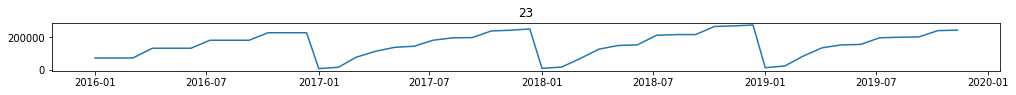

Оптимальный параметр преобразования Бокса-Кокса:  0.7469023529032814
Критерий Дики-Фуллера: p = 5.395798140081675e-08


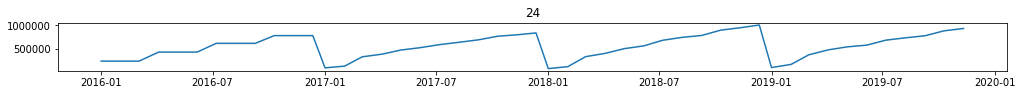

Оптимальный параметр преобразования Бокса-Кокса:  0.7731368732848559
Критерий Дики-Фуллера: p = 0.47603834691046676


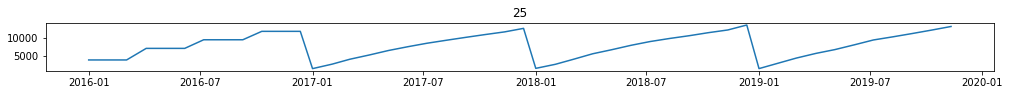

Оптимальный параметр преобразования Бокса-Кокса:  0.6691028292456054
Критерий Дики-Фуллера: p = 6.182084367033816e-08


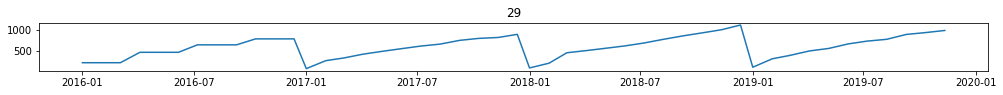

Оптимальный параметр преобразования Бокса-Кокса:  0.5480755175608771
Критерий Дики-Фуллера: p = 0.010380767081308546


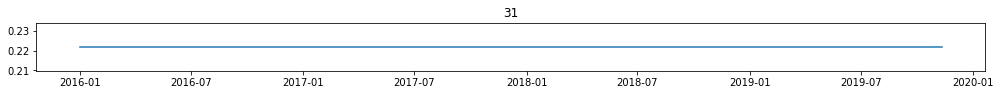

Оптимальный параметр преобразования Бокса-Кокса:  -4.50465837042782
Критерий Дики-Фуллера: p = nan


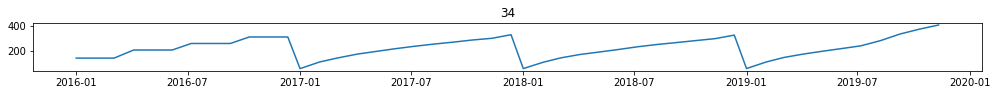

Оптимальный параметр преобразования Бокса-Кокса:  0.46682449307779317
Критерий Дики-Фуллера: p = 2.7916189820571147e-06


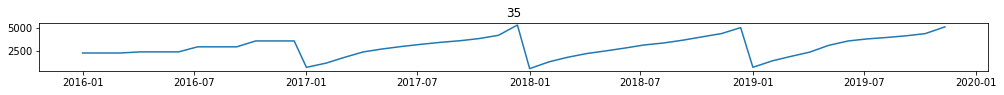

Оптимальный параметр преобразования Бокса-Кокса:  0.5428638246483715
Критерий Дики-Фуллера: p = 0.007283321491052989


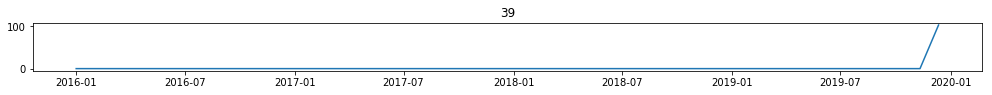

Оптимальный параметр преобразования Бокса-Кокса:  -6.678677705227183
Критерий Дики-Фуллера: p = 0.8136423448153273
Wall time: 3.7 s


In [72]:
%%time
for element in a_nonstat:
    plt.figure(figsize=(17,3))
    ax=plt.subplot(311)
    plt.title(element)
    factors_nsk[element][:-1], lmbda = stats.boxcox(factors_nsk[element][:-1])
    plt.plot(factors_nsk[element])
    plt.show()
    print("Оптимальный параметр преобразования Бокса-Кокса: ", lmbda)
    print("Критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(factors_nsk[element][:-1])[1])


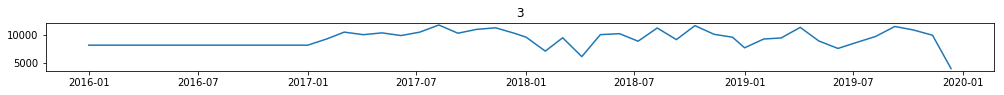

Пропущено значений: 0 , критерий Дики-Фуллера: p = 0.0005063828063074838


In [31]:
element=3

if factors_nsk[element].isna().sum() > 1:
    factors_nsk[element][-2]=factors_nsk[element][-3]
    
plt.figure(figsize=(17,3))
ax=plt.subplot(311)
plt.title(element)
plt.plot(factors_nsk[element])
plt.show()
    
print("Пропущено значений:", factors_nsk[element][:-1].isna().sum(), 
      ", критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(factors_nsk[element][:-1])[1])

ps = range(0, 2)
d=1
qs = range(0, 12)
Ps = range(0, 3)
D=1
Qs = range(0, 3)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
best_aic = float("inf")

if sm.tsa.stattools.adfuller(factors_nsk[element][:-1])[1] > 0.05:
    for param in parameters_list:
        try:
            model=sm.tsa.statespace.SARIMAX(factors_nsk[element][:-1], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        except ValueError:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
            print(best_param, best_aic)



In [ ]:
%%time
for element in [1,2,3,4,5,6,7,8,11,12,16,20,21,22,23,24,25,27,29,30,31,34,35,39]:
    c='g'
    if sm.tsa.stattools.adfuller(factors_nsk[element][:-1])[1] > 0.05:
        c='r'
    plt.figure(figsize=(17,3))
    ax=plt.subplot(311)
    plt.title(element)
    plt.plot(factors_nsk[element], c=c)
    plt.show()
    if factors_nsk[element].isna().sum() > 1:
        factors_nsk[element][-2]=factors_nsk[element][-3]
    print("Пропущено значений:", factors_nsk[element][:-1].isna().sum(), 
          ", критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(factors_nsk[element][:-1])[1])
    
    ps = range(0, 2)
    d=1
    qs = range(0, 12)
    Ps = range(0, 3)
    D=1
    Qs = range(0, 3)
    parameters = product(ps, qs, Ps, Qs)
    parameters_list = list(parameters)
    best_aic = float("inf")
    
    if sm.tsa.stattools.adfuller(factors_nsk[element][:-1])[1] < 0.05:
        for param in parameters_list:
            #try except нужен, потому что на некоторых наборах параметров модель не обучается
            try:
                model=sm.tsa.statespace.SARIMAX(factors_nsk[element][:-1], order=(param[0], d, param[1]), 
                                                seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
            #выводим параметры, на которых модель не обучается и переходим к следующему набору
            except ValueError:
                continue
            aic = model.aic
            #сохраняем лучшую модель, aic, параметры
            if aic < best_aic:
                best_model = model
                best_aic = aic
                best_param = param
                print(best_param, best_aic)
    
    if sm.tsa.stattools.adfuller(factors_nsk[element][:-1])[1] >=0.05:
        plt.figure(figsize=(17,3))
        ax=plt.subplot(311)
        plt.title(element)
        factors_nsk[element][:-1], lmbda = stats.boxcox(factors_nsk[element][:-1])
        plt.plot(factors_nsk[element], c='r')
        plt.show()
        print("Оптимальный параметр преобразования Бокса-Кокса: ", lmbda)
        print("Критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(factors_nsk[element][:-1])[1])
        for param in parameters_list:
            #try except нужен, потому что на некоторых наборах параметров модель не обучается
            try:
                model=sm.tsa.statespace.SARIMAX(factors_nsk[element][:-1], order=(param[0], d, param[1]), 
                                                seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
            #выводим параметры, на которых модель не обучается и переходим к следующему набору
            except ValueError:
                continue
            aic = model.aic
            #сохраняем лучшую модель, aic, параметры
            if aic < best_aic:
                best_model = model
                best_aic = aic
                best_param = param
                print(best_param, best_aic)